# Tomato Disease Classification with CNN

# Import Libraries

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

from PIL import Image

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Load Data

**Citation** 
<br />
Huang, Mei-Ling; Chang, Ya-Han (2020), “Dataset of Tomato Leaves”, Mendeley Data, 
<br />
V1, doi: 10.17632/ngdgg79rzb.1

In [3]:
os.chdir("/kaggle/input/dataset-of-tomato-leaves/plant_village")
print(os.listdir())

TRAINING_DIR = os.path.join('/kaggle/input/dataset-of-tomato-leaves/plant_village/train')
VALIDATION_DIR = os.path.join('/kaggle/input/dataset-of-tomato-leaves/plant_village/val')
TESTING_DIR = os.path.join('/kaggle/input/dataset-of-tomato-leaves/plant_village/test')

['val', 'test', 'train']


In [4]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(TRAINING_DIR,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 8715 files belonging to 10 classes.


2022-10-23 11:01:32.235927: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 11:01:32.236943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 11:01:32.541585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 11:01:32.542448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 11:01:32.543215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [6]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(VALIDATION_DIR,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2902 files belonging to 10 classes.


In [7]:
test_dataset = tf.keras.utils.image_dataset_from_directory(TESTING_DIR,
                                                           shuffle=False,
                                                           labels='inferred',
                                                           label_mode='categorical',
                                                           image_size=IMG_SIZE)

Found 2914 files belonging to 10 classes.


In [8]:
class_names = train_dataset.class_names
class_names

['Bacterial_spot',
 'Early_blight',
 'Healthy',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato_mosaic_virus',
 'Two_spotted_spider_mite']

# Visualize Training Data for each Class

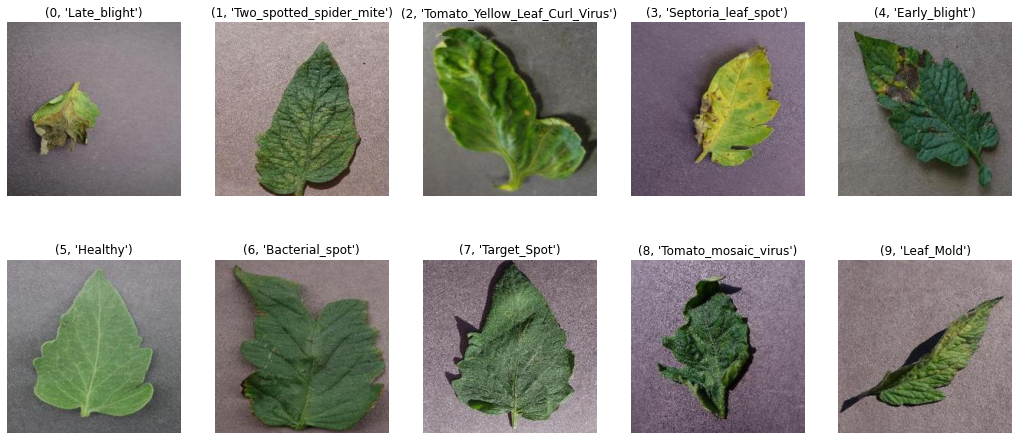

In [9]:
classes = os.listdir('./train')

plt.figure(figsize=(18,8))

for i in enumerate(classes):
    pic = os.listdir('./train/'+i[1])[0]
    image = Image.open('./train/'+i[1]+'/'+pic)
    image = np.asarray(image)
    plt.subplot(2, 5, i[0]+1)
    plt.title(i)
    plt.imshow(image)
    plt.axis("off")
plt.show()

# Data Summary

In [10]:
categories = []
train = []
val = []
test = []

folders = os.listdir('/kaggle/input/dataset-of-tomato-leaves/plant_village/train')
for f in folders:
    categories.append(f)
    train.append(len(os.listdir(os.path.join('/kaggle/input/dataset-of-tomato-leaves/plant_village/train', f))))

folders = os.listdir('/kaggle/input/dataset-of-tomato-leaves/plant_village/val')
for f in folders:
    val.append(len(os.listdir(os.path.join('/kaggle/input/dataset-of-tomato-leaves/plant_village/val', f))))

folders = os.listdir('/kaggle/input/dataset-of-tomato-leaves/plant_village/val')
for f in folders:
    test.append(len(os.listdir(os.path.join('/kaggle/input/dataset-of-tomato-leaves/plant_village/test', f))))

data_count = pd.DataFrame({'categories': categories,
                     'train': train,
                     'val': val,
                     'test': test                     
                    })

data_count

,categories,train,val,test
0,Late_blight,916,305,307
1,Two_spotted_spider_mite,804,268,269
2,Tomato_Yellow_Leaf_Curl_Virus,2571,857,858
3,Septoria_leaf_spot,850,283,284
4,Early_blight,480,160,160
5,Healthy,763,254,255
6,Bacterial_spot,1021,340,341
7,Target_Spot,674,224,226
8,Tomato_mosaic_virus,179,59,61
9,Leaf_Mold,457,152,153


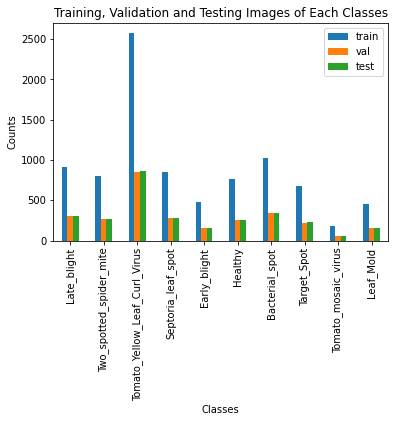

In [11]:
data_count.plot.bar(x='categories', title="Training, Validation and Testing Images of Each Classes")
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.show()

In [12]:
# Configure the dataset for performance
# Use buffered prefetching to load images from disk without having I/O become blocking.

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

In [13]:
def data_augmentation(x):
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(factor=0.2),
    ])(x)

2022-10-23 11:01:40.543916: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


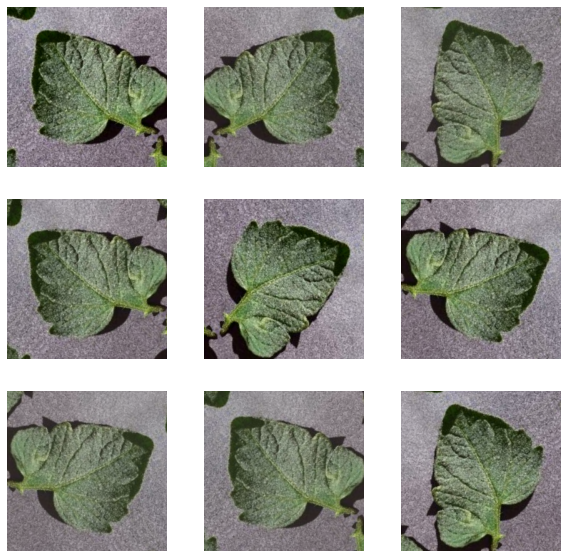

In [14]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Utility Functions

In [15]:
def preprocess_input(x): 
    return tf.keras.layers.Rescaling(1./255, offset=-1)(x)


def feature_extractor(x):
    x = tf.keras.layers.Conv2D(input_shape=(IMG_SIZE), filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(input_shape=(IMG_SIZE), filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
    
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
    
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
    
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
    
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    return x


def classifier(x):
    x = tf.keras.layers.Dense(264, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(264, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x


def prediction_layer(x):
    return tf.keras.layers.Dense(10, activation='softmax')(x)

# Define Model

In [16]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = feature_extractor(x)
x = classifier(x)

outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

# Compile the Model

In [17]:
learning_rate = 0.00001

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_9 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128   

# Add Callbacks

In [19]:
os.chdir("/kaggle/working")

log_csv = CSVLogger('./custom_NN_logs1.csv', separator=',', append=False)
checkpoint = ModelCheckpoint('./custom_NN.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

callbacks_list = [checkpoint, early_stop, log_csv]

# Fit the Model

In [20]:
epochs = 100

In [21]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)

Epoch 1/100


2022-10-23 11:01:49.268563: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


273/273 [==============================] - 104s 300ms/step - loss: 1.5784 - accuracy: 0.4853 - val_loss: 2.8203 - val_accuracy: 0.1103

Epoch 00001: val_loss improved from inf to 2.82025, saving model to ./custom_NN.hdf5
Epoch 2/100
273/273 [==============================] - 73s 265ms/step - loss: 1.0027 - accuracy: 0.6649 - val_loss: 1.5895 - val_accuracy: 0.4948

Epoch 00002: val_loss improved from 2.82025 to 1.58955, saving model to ./custom_NN.hdf5
Epoch 3/100
273/273 [==============================] - 73s 266ms/step - loss: 0.7966 - accuracy: 0.7337 - val_loss: 0.4873 - val_accuracy: 0.8387

Epoch 00003: val_loss improved from 1.58955 to 0.48727, saving model to ./custom_NN.hdf5
Epoch 4/100
273/273 [==============================] - 73s 264ms/step - loss: 0.6393 - accuracy: 0.7846 - val_loss: 0.4435 - val_accuracy: 0.8539

Epoch 00004: val_loss improved from 0.48727 to 0.44348, saving model to ./custom_NN.hdf5
Epoch 5/100
273/273 [==============================] - 73s 264ms/step -

# Plot Learning Curves

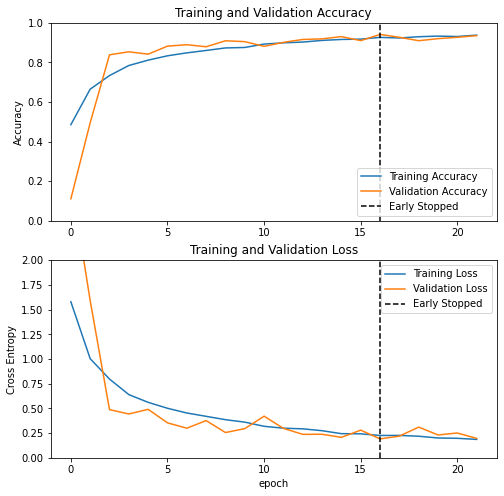

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.ylim([0.0, 1])
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([len(acc)-6, len(acc)-6], plt.ylim(), 
         label='Early Stopped', linestyle='--', color='black')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.ylim([0.0, 2.0])
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([len(acc)-6, len(acc)-6], plt.ylim(), 
         label='Early Stopped', linestyle='--', color='black')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [23]:
os.chdir("/kaggle/input/dataset-of-tomato-leaves/plant_village")

CLASSES = []

folders = os.listdir(TESTING_DIR)
for f in folders:
    CLASSES.append(f)
    
CLASSES

['Late_blight',
 'Two_spotted_spider_mite',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Septoria_leaf_spot',
 'Early_blight',
 'Healthy',
 'Bacterial_spot',
 'Target_Spot',
 'Tomato_mosaic_virus',
 'Leaf_Mold']

# Prediction and Evaluation

In [24]:
predictions = np.array([])
labels =  np.array([])

for x, y in test_dataset:
    predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

Evaluating the Algorithm

Accuracy: 		 0.9406314344543583
Precision: 		 0.9439073984952723
Recall: 		 0.9406314344543583
F1 score: 		 0.9406314344543583 



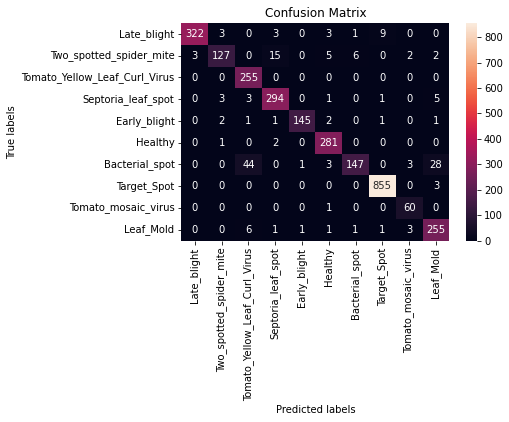

In [25]:
print('Evaluating the Algorithm\n')
print('Accuracy: \t\t', accuracy_score(labels, predictions))
print('Precision: \t\t', precision_score(labels, predictions, average='weighted'))
print('Recall: \t\t', recall_score(labels, predictions, average='weighted'))
print('F1 score: \t\t', f1_score(labels, predictions, average='micro'), '\n')

# Confusion Matrix
cf = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

ax= plt.subplot()
sns.heatmap(cf, annot=True, fmt='g', ax=ax);

ax.set_title('Confusion Matrix'); 

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 

ax.xaxis.set_ticklabels(CLASSES); 
ax.yaxis.set_ticklabels(CLASSES);

plt.xticks(rotation = 90)
plt.yticks(rotation = 360)

plt.show()